## TP: Réaliser des clusters avec l'algorithme K-means 

Le dataset Palmer Penguin est un ensemble de données qui contient des images de manchots de différentes espèces et sous-espèces, recueillies sur l'île de Palmer en Antarctique. Il a été créé par des chercheurs universitaires pour aider à la reconnaissance automatique des espèces de manchots. Il permet de tester l'algorithme K-means en utilisant des images pour regrouper les manchots similaires ensemble et en utilisant des caractéristiques visuelles similaires pour le clustering. Il a une classification précise pour évaluer la performance de l'algorithme.

Vous pouvez le télécharger sous le lien suivant : 
https://www.kaggle.com/code/parulpandey/penguin-dataset-the-new-iris/notebook

## Charger les librairies 

In [6]:
!pip install seaborn
import pandas as pd 
import numpy as np 
import math 
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score


## Charger les données

Le lien précédent vous donne accès à deux fichiers "penguins_size.csv" & "penguins_lter.csv". Nous avons choisi de restreindre notre étude à un seul fichier csv. 

In [7]:
Penguin = pd.read_csv('penguins_size.csv')


## Découvrir et Visualiser les données pour en tirer des informations

In [8]:
print(Penguin.head())

  species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen              39.1             18.7              181.0   
1  Adelie  Torgersen              39.5             17.4              186.0   
2  Adelie  Torgersen              40.3             18.0              195.0   
3  Adelie  Torgersen               NaN              NaN                NaN   
4  Adelie  Torgersen              36.7             19.3              193.0   

   body_mass_g     sex  
0       3750.0    MALE  
1       3800.0  FEMALE  
2       3250.0  FEMALE  
3          NaN     NaN  
4       3450.0  FEMALE  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

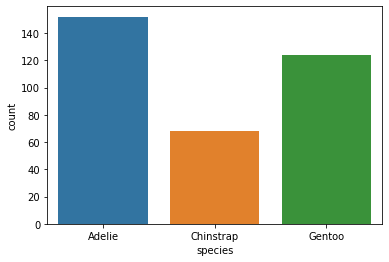

In [9]:
#Exploration des données 
sns.countplot(x = "species", data = Penguin)

#Recherche des valeurs manquantes
Penguin.info()
Penguin.isna().sum()

Nous remarquons que la colonne "sex" a le plus de valeurs manquantes. Aussi, l'espèce "Adelie" est la plus présente. 

## Préparer les données 

Il est important de nettoyer et de préparer les données avant de les utiliser pour l'apprentissage automatique. Cela peut inclure des tâches telles que la suppression des données manquantes, la normalisation des données et la transformation des données pour qu'elles soient utilisables par l'algorithme. Etant donné que nous allons faire de l'apprentissage non-supervisé, nous n'allons pas nous servir de la colonne "species" qui est la colonne de sortie (colonne des étiquettes) pour l'entrainement. Nous pourrons l'utiliser à la fin pour évaluer notre modèle. 

In [10]:
#Suppression des données manquantes 
Penguin = Penguin.dropna()

#Normalisation des données 
scaler = StandardScaler()
Penguin[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']] = scaler.fit_transform(Penguin[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']])

#Encodage des variables categorielles
le = LabelEncoder()
Penguin['sex'] = le.fit_transform(Penguin['sex'])
Penguin['island'] = le.fit_transform(Penguin['island'])
Penguin['species'] = le.fit_transform(Penguin['species'])

#création de la variable d'évaluation species et suppression de la colonne species
species = Penguin["species"]
del Penguin["species"]


Penguin

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,2,-0.897653,0.783487,-1.429521,-0.571229,2
1,2,-0.824290,0.121896,-1.072408,-0.509011,1
2,2,-0.677564,0.427246,-0.429605,-1.193405,1
4,2,-1.337831,1.088836,-0.572450,-0.944535,1
5,2,-0.860972,1.750427,-0.786718,-0.695664,2
...,...,...,...,...,...,...
338,0,0.587947,-1.761093,0.927425,0.890886,1
340,0,0.514584,-1.455743,0.998847,0.797560,1
341,0,1.174851,-0.743261,1.498806,1.917477,2
342,0,0.221132,-1.201285,0.784580,1.233083,1


## Choisir le nombre de clusters  

D'après le dataset original, nous avons 3 étiquettes donc k=3. Mais pour les besoins de ce tutoriel, nous allons nous servir des techniques pour trouver le nombre optimal de clusters et ainsi confimer que k=3. 

Il existe plusieurs méthodes pour choisir le nombre de clusters pour un dataset donné, nous allons nous servir de la méthode de l'écart intra-classe (ou "Elbow Method"). Cette méthode consiste à tracer la somme des carrés intra-clusters (ou "inertie") en fonction du nombre de clusters. Le nombre de clusters optimal est généralement celui pour lequel l'augmentation de l'inertie est la plus faible. Avant ce point k, la variance expliquée augmente rapidement avec l'augmentation du nombre de clusters, mais après ce point, l'augmentation de la variance expliquée est plus linéaire, c'est à dire plus faible.

C:\Users\miaou\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


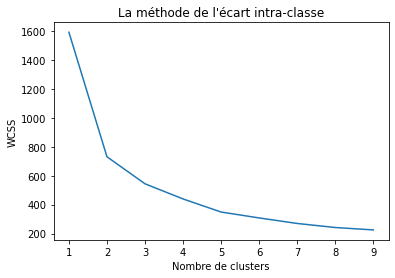

In [11]:
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(Penguin)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('La méthode de l\'écart intra-classe')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')
plt.show()

En prenant en compte, le critère d'évaluation précedent, k=3 et k=5 apparaissant comme étant de bonnes valeurs potentielles. Pour faire le choix entre ces deux valeurs nous allons utiliser une deuxième méthode: la méthode de score de silhouette. Elle est utilisée pour déterminer le nombre optimal de clusters (k) en trouvant celui qui donne les meilleurs scores de silhouette. Cela consiste à calculer le score de silhouette pour différentes valeurs de k, puis à tracer un graphique des scores de silhouette en fonction de k. La valeur de k pour laquelle les scores de silhouette sont les plus élevés est considérée comme étant la meilleure segmentation en cluster.

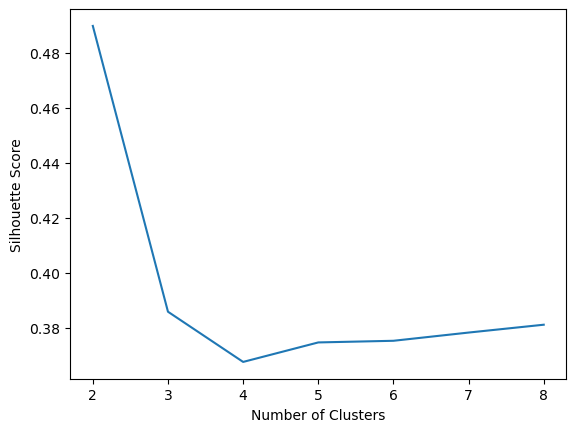

In [7]:
range_n_clusters = range(2,9)
scores = []
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(Penguin)
    silhouette_avg = silhouette_score(Penguin, kmeans.labels_)
    scores.append(silhouette_avg)

# Tracer les scores de silhouette en fonction du nombre de clusters
plt.plot(range_n_clusters, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Ce graphique nous permet donc de confirmer la valeur de k qui est de 3. 

# Entrainer l'algorithme 
Une fois que les données sont préparées et que le nombre de clusters est défini, l'algorithme K-means peut être entraîné sur les données.

Il est important de noter que l'algorithme K-means a besoin de choisir des centres de clusters initiaux pour commencer, il existe plusieurs stratégies pour le faire : 

-Choisir les centres initiaux aléatoirement: C'est la stratégie par défaut utilisée par l'implémentation de Scikit-learn.

-Utiliser la stratégie k-means++ pour choisir les centres initiaux: Cette stratégie consiste à choisir les centres initiaux en utilisant une stratégie de sélection pondérée qui vise à minimiser la somme des carrés intra-clusters pour les centres initiaux choisis. 

-Utiliser des données précédemment étiquetées pour choisir les centres initiaux.

-Générer des données aléatoires pour choisir les centres initiaux: Cette stratégie consiste à générer des données aléatoires qui serviront de centres initiaux pour l'algorithme. 

Nous allons utiliser la stratégie k-means++.

In [25]:
#Initialisation de l'algorithme et choix de la méthode permettant de choisir les centres de clusters initiaux 
kmeans = KMeans(n_clusters=3, init = 'k-means++')

#Entrainement de l'algorithme sur le jeu de données 
kmeans.fit(Penguin)

#Prédication des clusters 
y_pred = kmeans.predict(Penguin)


# Evaluer l'algorithme 
Il existe plusieurs méthodes pour évaluer la qualité d'un modèle k-means. Les méthodes les plus couramment utilisées sont les suivantes:

Indice de Rand (Rand index): Il mesure la similitude entre les prédictions et les variables de sortie initiales en comparant les paires d'éléments qui ont été correctement classés ou non. Il varie entre 0 et 1, où une valeur de 1 indique une correspondance parfaite entre les prédictions et les variables de sortie initiales.

Indice de Jaccard (Jaccard index): Il mesure la similitude entre les prédictions et les variables de sortie initiales en comparant le nombre d'éléments qui ont été correctement classés sur le nombre total d'éléments. Il varie entre 0 et 1, où une valeur de 1 indique une correspondance parfaite entre les prédictions et les variables de sortie initiales.

Score de V-mesure (V-measure score): Il est une combinaison de l'indice de Rand et de l'indice de Jaccard. Il prend en compte à la fois la similitude entre les prédictions et les variables de sortie initiales et le nombre de clusters dans les deux ensembles de données. Il varie entre 0 et 1, où une valeur de 1 indique une correspondance parfaite entre les prédictions et les variables de sortie initiales.

Score de silhouette (Silhouette score) : Il évalue la qualité de l'affectation des points de données à des clusters en comparant la proximité des points de données à leur propre cluster et à d'autres clusters. Il varie entre -1 et 1, où une valeur de 1 indique une affectation très bonne des points de données à des clusters.

Nous allons combiner ces méthodes pour obtenir une évaluation complète de la qualité du modèle k-means.

In [26]:
#Calculer le V-measure score
v_measure = v_measure_score(species, y_pred)
print("Score de V-mesure: ", v_measure)

#Calculer l'indice de silhouette
silhouette = silhouette_score(Penguin, y_pred)
print("Indice de silhouette: ", silhouette)


Score de V-mesure:  0.7605670701550687
Indice de silhouette:  0.3858405430625669


V-mesure est très proche de 1, En général, une valeur proche de 1 indique que les prédictions sont très similaires aux variables de sortie initiales. 
Par contre, notre silhouette score est très proche de 0. Une valeur proche de 0 indique que les points de données sont sur la frontière entre les clusters.

# Amelioration de Kmeans 

À vous de jouer !
Le but est d'améliorer ce score grâce aux différentes méthodes de nettoyage de données et aussi des paramètres de kmeans! 

In [100]:
Penguin_2=Penguin.copy() #on enlève la feature island car les données sont qualitatifs (pas un bonne solution après vérification)
Penguin_2.drop(columns="island")

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,-0.897653,0.783487,-1.429521,-0.571229,2
1,-0.824290,0.121896,-1.072408,-0.509011,1
2,-0.677564,0.427246,-0.429605,-1.193405,1
4,-1.337831,1.088836,-0.572450,-0.944535,1
5,-0.860972,1.750427,-0.786718,-0.695664,2
...,...,...,...,...,...
338,0.587947,-1.761093,0.927425,0.890886,1
340,0.514584,-1.455743,0.998847,0.797560,1
341,1.174851,-0.743261,1.498806,1.917477,2
342,0.221132,-1.201285,0.784580,1.233083,1


In [122]:
#on répartie les islands sur 3 columns (pas une bonne solution)
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

Penguin_3= pd.read_csv('penguins_size.csv')
Penguin_3 = Penguin_3.dropna()
le = LabelEncoder()

Penguin_3['sex'] = le.fit_transform(Penguin_3['sex'])

Penguin_3['species'] = le.fit_transform(Penguin_3['species'])

species = Penguin_3["species"]

del Penguin_3["species"]

pipe_num = Pipeline([("scaler",StandardScaler())])

pipe_cat = Pipeline([("one_hot",OneHotEncoder(sparse=False))])

preprocess_pipeline = ColumnTransformer([
        ("num", pipe_num, ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g','sex']),
        ("cat", pipe_cat, ['island']),
    ])

Penguin_3=preprocess_pipeline.fit_transform(Penguin_3)


Penguin_3

array([[-0.89765322,  0.78348666, -1.42952144, ...,  0.        ,
         0.        ,  1.        ],
       [-0.82429023,  0.12189602, -1.07240838, ...,  0.        ,
         0.        ,  1.        ],
       [-0.67756427,  0.42724555, -0.42960487, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.17485108, -0.74326098,  1.49880565, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.22113229, -1.20128527,  0.78457953, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.08314735, -0.53969463,  0.85600214, ...,  1.        ,
         0.        ,  0.        ]])

In [125]:
#Initialisation de l'algorithme et choix de la méthode permettant de choisir les centres de clusters initiaux 
kmeans_2 = KMeans(n_clusters=3, init = 'k-means++',max_iter=300,random_state=1)

#Entrainement de l'algorithme sur le jeu de données 
kmeans_2.fit(Penguin_3)

#Prédication des clusters 
y_pred = kmeans_2.predict(Penguin_3)


In [126]:
#Calculer le V-measure score
v_measure = v_measure_score(species, y_pred)
print("Score de V-mesure: ", v_measure)

#Calculer l'indice de silhouette
silhouette = silhouette_score(Penguin, y_pred)
print("Indice de silhouette: ", silhouette)

Score de V-mesure:  0.6072543810384697
Indice de silhouette:  0.36057653870983103
